# Distributional word representations (Exercise 2 + Homework 1)

Much of this taken from Christopher Potts' CS224u course from Spring 2016.

In [1]:
__author__ = "Nishant Subramani"
__version__ = "DSGA 1012, NYU, Spring 2018 term"

## Contents

0. [Overview](#Overview)
0. [Set-up](#Set-up)
0. [Distributional matrices](#Distributional-matrices)
0. [Vector comparison](#Vector-comparison)
    0. [Euclidean distance](#Euclidean-distance)
    0. [Length normalization](#Length-normalization)
    0. [Cosine distance](#Cosine-distance)
    0. [Summary](#Summary)
0. [Distributional neighbors](#Distributional-neighbors)    
0. [Matrix reweighting](#Matrix-reweighting)
    0. [Normalization](#Normalization)
    0. [Pointwise Mutual Information](#Pointwise-Mutual-Information)
0. [Dimensionality reduction](#Dimensionality-reduction)
0. [Word analogies evaluation](#Word-analogies-evaluation)
0. [Homework 1](#Homework-1)

## Overview

In this exercise and assignment, we want to explore creating vector representations of words (__distributional representations__) from co-occurence patterns in text.

## Set-up

First, install matplotlib using conda. The command below should work. 

Note: If any of the below imports fail, you have to conda install them as well. Google conda install package-name and you will find a command to run.

* Make sure your environment includes all the requirements for [the cs224u repository](https://github.com/cgpotts/cs224u).
* Download [the data distribution for this unit](https://web.stanford.edu/class/cs224u/data/vsmdata.zip), unpack it, and place it in the directory containing the course repository. (If you want to put it somewhere else, change `vsmdata_home` below.)
* Download [the Wikipedia 2014 + Gigaword 5 distribution](http://nlp.stanford.edu/data/glove.6B.zip) of the pretrained GloVe vectors, unzip it, and put the resulting folder in the the same directory as this notebook. (If you want to put it somewhere else, change `glove_home` below.)

In [2]:
vsmdata_home = "data/vsmdata"
glove_home = "data/glove.6B"

In [3]:
import os
import sys
import csv
import random
import itertools
from operator import itemgetter
from collections import defaultdict
import numpy as np
#import scipy
#import scipy.spatial.distance
from numpy.linalg import svd
import matplotlib.pyplot as plt
#from sklearn.decomposition import PCA
#from sklearn.manifold import TSNE
import utils

np.set_printoptions(suppress=True)

In [4]:
%matplotlib inline

## Distributional matrices

Here's a basic recipe for building a word $\times$ word matrix:
    
0. Define a notion of co-occurrence context. This could be an entire document, a paragraph, a sentence, a clause, an NP — whatever domain seems likely to capture the associations you care about.
0. Scan through your corpus building a dictionary $d$ mapping word-pairs to counts. Every time a pair of words $w$ and $w'$ occurs in the same context (as you defined it in 1),  increment $d[(w, w')]$ by $1$.
0. Using the count dictionary $d$ that you collected in 2, establish your full vocabulary $V$, an ordered list of words types. For large collections of documents, $|V|$ will typically be huge. You will probably want to winnow the vocabulary at this point. You might do this by filtering to a specific subset, or just imposing a minimum count threshold. You might impose a minimum count threshold even if $|V|$ is small &mdash; for words with very low counts, you simply don't have enough evidence to say anything interesting.
0. Now build a matrix $M$ of dimension $|V| \times |V|$. Both the rows and the columns of $M$ represent words. Each cell $M[i, j]$ is filled with the count $d[(w_i, w_j)]$.

For different designs, the procedure differs slightly. For example, if you are building a word $\times$ document matrix, then the rows of $M$ represent words and the columns of $M$ represent documents. The scan in step 2 then just keeps track of (_word_, _document_) pairs &mdash; compiling the number of times that _word_ appears in _document_. Such matrices are often used in information retrieval, because the columns are multi-set representations of documents. They are much sparser than the the word $\times$ word matrices we will work with here. (In my experience, they yield lower-quality lexicons, but others have reported good results with them.)

The data distribution includes two pre-computed matrices of co-occurrence counts in IMDB movie reviews. The `build` function in the `utils` module for this repository  allows you to read them in:

Let's read these in now for use in later examples:

In [5]:
ww = utils.build(os.path.join(vsmdata_home, 'imdb-wordword.csv'))
wd = utils.build(os.path.join(vsmdata_home, 'imdb-worddoc.csv'))

There are some great pre-computed matrices available online too. These aren't matrices of counts, but rather more abstract values computed using methods like those under discussion here. [GloVe](https://nlp.stanford.edu/projects/glove/) is a unsupervised learning algorithm that learns vector representations of words using word-to-word cooccurence matrices from a corpus. Let's explore them a bit and load in some [GloVe vectors](#GloVe-word-representations):

In [6]:
glv = utils.build_glove(os.path.join(glove_home, 'glove.6B.50d.txt'))

## Vector comparison

Vector comparisons form the heart of our analyses in this context. For the most part, we are interested in measuring the _distance_ between vectors. We surmise that semantically related words should be close together and semantically unrelated words should be far apart in the vector spaces we build.

### Euclidean distance

The most basic and intuitive distance measure between vectors is __euclidean distance__. The euclidean distance between two vectors $u$ and $v$ of dimension $n$ is 

$$\sqrt{\sum_{i=1}^{n} |u_{i}-v_{i}|^2}$$ 

In two-dimensions, this corresponds to the length of the most direct line between the two points.

As part of the exercise, implement this without using any other packages beyond what has been imported already.

In [7]:
def euclidean(u, v):    
    """Eculidean distance between 1d np.arrays `u` and `v`, which must 
    have the same dimensionality. Returns a float."""
    return np.sqrt(np.sum(np.square(u-v)))

The comment above shows how to define this measure yourself. The function used there is the __length__ of a vector $u$ of dimension $n$, which is defined as 

$$\|u\| = \sqrt{\sum_{i=1}^{n} u_{i}^{2}}$$ 

Please fill in vector_length below:

In [8]:
def vector_length(u):
    """Length (L2) of the 1d np.array `u`. Returns a new np.array with the 
    same dimensions as `u`."""
    return np.sqrt(u.dot(u))

Here's a tiny vector space:

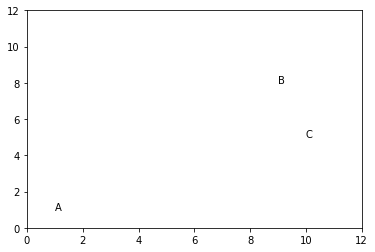

In [9]:
ABC = np.array([
    [ 1.0,  1.0],  # A
    [9.0, 8.0],  # B
    [10.0, 5.0]]) # C

def plot_ABC(m):
    plt.plot(m[:,0], m[:,1], marker='', linestyle='')
    plt.xlim([0,np.max(m)*1.2])
    plt.ylim([0,np.max(m)*1.2])
    for i, x in enumerate(['A','B','C']):
        plt.annotate(x, m[i,:])

plot_ABC(ABC)

The euclidean distances align well with the raw visual distance in the plot:

In [10]:
euclidean(ABC[0], ABC[1])

10.63014581273465

In [11]:
euclidean(ABC[1], ABC[2])

3.1622776601683795

### Length normalization

Normalization changes the affinity or distance between points A, B, and C dramatically. Is normalization the right thing to do?

In [12]:
def length_norm(u):
    """L2 norm of the 1d np.array `u`. Returns a float."""
    return u / vector_length(u)

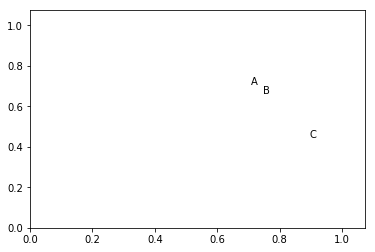

In [13]:
plot_ABC(np.array([length_norm(row) for row in ABC]))

Here, the connection between A and B is more apparent, as is the opposition between B and C.

### Cosine distance

__Cosine distance__ takes overall length into account. The cosine distance between two vectors $u$ and $v$ of dimension $n$ is 

$$1 - \left(\frac{\sum_{i=1}^{n} u_{i} \cdot v_{i}}{\|u\|\cdot \|v\|}\right)$$

The similarity part of this (the righthand term of the subtraction) is actually measuring the _angles_ between the two vectors. The result is the same (in terms of rank order) as one gets from first normalizing both vectors using `vector_length` and then calculating their Euclidean distance.

Implement this below:

In [14]:
def cosine(u, v):        
    """Cosine distance between 1d np.arrays `u` and `v`, which must have 
    the same dimensionality. Returns a float."""
    return 1 - (u.dot(v) / (vector_length(u) * vector_length(v)))

### Summary

Suppose we set for ourselves the goal of associating A with B and disassociating B from C, in keeping with the semantic intuition expressed above. Then we can assess distance measures by whether they achieve this goal:

In [15]:
for m in (euclidean, cosine):
    fmt = {'n': m.__name__,  
           'AB': m(ABC[0], ABC[1]), 
           'BC': m(ABC[1], ABC[2])}
    print('%(n)15s(A, B) = %(AB)5.2f %(n)15s(B, C) = %(BC)5.2f' % fmt)

      euclidean(A, B) = 10.63       euclidean(B, C) =  3.16
         cosine(A, B) =  0.00          cosine(B, C) =  0.03


## Distributional neighbors

The `neighbors` function is an investigative aide. For a given `word`, it ranks all the words in the vocabulary `rownames` according to their distance from `word`, as measured by `distfunc` in matrix `mat`:

In [16]:
def neighbors(word, mat, rownames, distfunc=cosine):    
    """Tool for finding the nearest neighbors of `word` in `mat` according 
    to `distfunc`. The comparisons are between row vectors.
    
    Parameters
    ----------
    word : str
        The anchor word. Assumed to be in `rownames`.
        
    mat : np.array
        The vector-space model.
        
    rownames : list of str
        The rownames of mat.
            
    distfunc : function mapping vector pairs to floats (default: `cosine`)
        The measure of distance between vectors. Can also be `euclidean`, 
        `matching`, `jaccard`, as well as any other distance measure  
        between 1d vectors.
        
    Raises
    ------
    ValueError
        If word is not in rownames.
    
    Returns
    -------    
    list of tuples
        The list is ordered by closeness to `word`. Each member is a pair 
        (word, distance) where word is a str and distance is a float.
    
    """
    if word not in rownames:
        raise ValueError('%s is not in this VSM' % word)
    w = mat[rownames.index(word)]
    dists = [(rownames[i], distfunc(w, mat[i])) for i in range(len(mat))]
    return sorted(dists, key=itemgetter(1), reverse=False)

By playing around with this function, you can start to get a sense for how the distance functions differ. Here are some example calls; you might try some new words to get a feel for what these matrices are like and how different words look.

In [17]:
neighbors(word='superb', mat=ww[0], rownames=ww[1], distfunc=cosine)[: 5]

[('superb', 0.0),
 ('excellent', 0.0026965023912962627),
 ('outstanding', 0.0027344413235226295),
 ('beautifully', 0.0027345163104325332),
 ('brilliant', 0.0027888643627086429)]

In [18]:
neighbors(word='superb', mat=ww[0], rownames=ww[1], distfunc=euclidean)[: 5]

[('superb', 0.0),
 ('familiar', 1448.8919904533948),
 ('violent', 1630.3723501090174),
 ('follows', 1647.0276257549538),
 ('convincing', 1701.2260284865147)]

The above rankings actually tend to look pretty good, with `cosine` less likely to associate words that happen to have similar frequency. 

The GloVe vectors look even better &mdash; but they are based on much more than just raw counts, as we'll see soon:

In [19]:
neighbors(word='superb', mat=glv[0], rownames=glv[1], distfunc=cosine)[: 5]

[('superb', 2.2204460492503131e-16),
 ('brilliant', 0.15809110259014769),
 ('impressive', 0.19352861376442654),
 ('masterful', 0.22871323564771906),
 ('excellent', 0.22928471014596685)]

## Matrix reweighting

Reweighting aims to amplify the important, trustworthy, and unusual, while deemphasizing the mundane and the quirky. The intuition behind moving away from raw counts is that just using frequency is too fuzzy a concept for our goal of encoding semantics.

### Normalization

Normalization (row-wise or column-wise) is perhaps the simplest form of reweighting. With [length_norm](#Length-normalization), we normalize using `vector_length`. We can also normalize each row by the sum of its values, which turns each row into a probability distribution over the columns:

In [20]:
def prob_norm(u):
    """Normalize 1d np.array `u` into a probability distribution. Assumes 
    that all the members of `u` are positive. Returns a 1d np.array of 
    the same dimensionality as `u`."""
    return u / np.sum(u)

Key Point: These normalization measures are insensitive to the _magnitude_ of the underlying counts. 

This is often a mistake in the messy world of large data sets; $[1,10]$ and $[1000,10000]$ are very different in ways that will be partly or totally obscured by normalization.

How do we solve this? PMI!

### Pointwise Mutual Information [2 points]

__Pointwise Mutual Information__ (PMI) addresses this issue, at least in part. The PMI for word $\times$ context pair $(w,c)$ is 

$$\log\left(\frac{P(w,c)}{P(w) \cdot P(c)}\right)$$

with $\log(0) = 0$. This is a measure of how far that cell's value deviates from what we would expect given the row and column sums for that cell. 

__Positive PMI__ (PPMI) maps all negative PMI values to 0.0. Our function `pmi` has `positive=True` as a default, in light of the arguments in [Levy and Goldberg 2014](http://papers.nips.cc/paper/5477-neural-word-embedding-as-implicit-matrix-factorization), section 3.3.

For the last part of the exercise, we want to you implement `pmi` and the `pmi_log` helper functions. We have given you a couple of comments to help you with this. If you don't finish this part, finish it for the homework. This will be worth 2 points.

In [21]:
def pmi(mat, rownames=None, positive=True):
    """Pointwise Mutual Information with Positive on by default.
    
    Parameters
    ----------
    mat : 2d np.array
       The matrix to operate on.
           
    rownames : list of str or None
        Not used; it's an argument only for consistency with other methods 
        defined here.
        
    positive : bool (default: True)
        Implements Positive PMI.
        
    Returns
    -------    
    (np.array, list of str)
       The first member is the PMI-transformed version of `mat`, and the 
       second member is `rownames` (unchanged).
    
    """
    # Joint probability table:
    joint = np.divide(mat, np.sum(mat))

    # Pre-compute column and row sums:
    col_sum = joint.sum(axis=0)
    row_sum = joint.sum(axis=1)

    # Vectorize this function so that it can be applied rowwise: 
    _v_pmi_log = np.vectorize(_pmi_log)
    
    # PMI transformation:
    p = _v_pmi_log(joint / np.outer(row_sum, col_sum))

    return (p, rownames)


def _pmi_log(x, positive=True):
    """With `positive=False`, return log(x) if possible, else 0.
    With `positive=True`, log(x) is mapped to 0 where negative."""
    val = 0
    
    if x != 0:
        val = np.log(x)
    
    if positive:
        if val < 0:
            val = 0

    return val

Here, we reweight the word $\times$ word IMDB matrix from above using PPMI:

In [22]:
ww_ppmi = pmi(mat=ww[0], rownames=ww[1], positive=True)

In [23]:
neighbors(word='superb', mat=ww_ppmi[0], rownames=ww_ppmi[1], distfunc=cosine)[:5]

[('superb', 0.0),
 ('excellent', 0.41348274842943578),
 ('performances', 0.44391628568702513),
 ('brilliant', 0.45785117509986162),
 ('performance', 0.46856555779383202)]

# Homework 1:

First complete all parts in the notebook you haven't completed yet. Go through the rest of the notebook. At the end of the notebook there are a few questions to complete. Please write your answers to the 4 questions in NYU classes when you submit the assignment. Note you have to submit the notebook as well due to PMI being graded.

## Dimensionality reduction

The above methods deliver solid results. However, they are not capable of capturing higher-order associations in the data. For example, both _gnarly_ and _wicked_ are used as slangily positive adjectives. We thus expect them to have many of the same neighbors. However, at least stereotypically, _gnarly_ is Californian and _wicked_ is Bostonian. Thus, they are unlikely 
to occur often in the same texts. Dimensionality reduction techniques are often capable of capturing their semantic similarity (and have the added advantage of shrinking the size of our data structures).

The general goal of dimensionality reduction is to eliminate rows/columns that are highly correlated while bringing similar things together and pushing dissimilar things apart. __Latent Semantic Analysis__ (LSA) is a prominent method. It is an application of truncated __singular value decomposition__ (SVD). SVD is a central matrix operation; 'truncation' here means looking only at submatrices of the full decomposition. LSA seeks not only to find a reduced-sized matrix but also to capture similarities that come not just from direct co-occurrence, but also from second-order co-occurrence.

In [24]:
def lsa(mat=None, rownames=None, k=100):
    """Latent Semantic Analysis using pure scipy.
    
    Parameters
    ----------
    mat : 2d np.array
       The matrix to operate on.
           
    rownames : list of str or None
        Not used; it's an argument only for consistency with other methods 
        defined here.
        
    k : int (default: 100)
        Number of dimensions to truncate to.
        
    Returns
    -------    
    (np.array, list of str)
        The first member is the SVD-reduced version of `mat` with 
        dimension (m x k), where m is the rowcount of mat and `k` is 
        either the user-supplied k or the column count of `mat`, whichever 
        is smaller. The second member is `rownames` (unchanged).

    """    
    rowmat, singvals, colmat = svd(mat, full_matrices=False)
    singvals = np.diag(singvals)
    trunc = np.dot(rowmat[:, 0:k], singvals[0:k, 0:k])
    return (trunc, rownames)

Here's a look at the example from the slides:

In [25]:
gnmat = np.array([
    [1,0,1,0,0,0],
    [0,1,0,1,0,0],
    [1,1,1,1,0,0],
    [0,0,0,0,1,1],
    [0,0,0,0,0,1]], dtype='float64')
gn_rownames = ['gnarly', 'wicked', 'awesome', 'lame', 'terrible']

In [26]:
neighbors(word='gnarly', mat=gnmat, rownames=gn_rownames, distfunc=cosine)

[('gnarly', 2.2204460492503131e-16),
 ('awesome', 0.29289321881345254),
 ('wicked', 1.0),
 ('lame', 1.0),
 ('terrible', 1.0)]

We see that _gnarly_ and _wicked_ are not close to each other. (Well, it's a small space, but they are as close as _gnarly_ and _lame_.) Reweighting by PMI, PPMI, or TF-IDF is no help. LSA to the rescue:

In [27]:
gnmat_lsa = lsa(mat=gnmat, rownames=gn_rownames, k=2)

In [28]:
neighbors(word='gnarly', mat=gnmat_lsa[0], rownames=gnmat_lsa[1], distfunc=cosine)

[('gnarly', 0.0),
 ('wicked', 0.0),
 ('awesome', 0.0),
 ('lame', 1.0),
 ('terrible', 1.0)]

## Word analogies evaluation

Word analogies provide another kind of evaluation for distributed representations. Here, we are given three vectors A, B, and C, in the relationship

_A is to B as C is to __ _

and asked to identify the fourth that completes the analogy. This section conducts such analyses using a large, automatically collected analogies datset from Google. These analogies are by and large substantially easier than the classic brain-teaser analogies that used to appear on tests like the SAT, but it's still an interesting, demanding
task. 

The core idea idea is that we make predictions by creating the vector

$$(A - B) + C$$ 

and then ranking all vectors based on their distance from this new vector, choosing the closest as our prediction.

In [29]:
def analogy_completion(a, b, c, mat, rownames, distfunc=cosine):
    """a is to be as c is to predicted, where predicted is the 
    closest to (b-a) + c"""
    for x in (a, b, c):
        if x not in rownames:
            raise ValueError('%s is not in this VSM' % x)
    avec = mat[rownames.index(a)]
    bvec = mat[rownames.index(b)]
    cvec = mat[rownames.index(c)]
    newvec = (bvec - avec) + cvec
    dists = [(w, distfunc(newvec, mat[i])) for i, w in enumerate(rownames) if w not in (a, b, c)]
    return sorted(dists, key=itemgetter(1), reverse=False)    

In [30]:
analogy_completion('dance', 'dancing', 'sing', 
    mat=ww_ppmi[0], rownames=ww_ppmi[1])[:5]

[('singing', 0.36387000688724291),
 ('songs', 0.43222308133082787),
 ('song', 0.4364868809575787),
 ('musical', 0.45341770142029214),
 ('musicals', 0.50284943344566313)]

In [31]:
def analogy_evaluation(
        mat, 
        rownames, 
        src_filename='gram1-adjective-to-adverb.txt', 
        distfunc=cosine):
    """Basic analogies evaluation for a file `src_filename `
    in `question-data/`.
    
    Parameters
    ----------    
    mat : 2d np.array
        The VSM being evaluated.
        
    rownames : list of str
        The names of the rows in `mat`.
        
    src_filename : str
        Basename of the file to be evaluated. It's assumed to be in
        `vsmdata_home`/question-data.
        
    distfunc : function mapping vector pairs to floats (default: `cosine`)
        The measure of distance between vectors. Can also be `euclidean`, 
        `matching`, `jaccard`, as well as any other distance measure 
        between 1d vectors.
    
    Returns
    -------
    (float, float)
        The first is the mean reciprocal rank of the predictions and 
        the second is the accuracy of the predictions.
    
    """
    src_filename = os.path.join(vsmdata_home, 'question-data', src_filename)
    # Read in the data and restrict to problems we can solve:
    data = [line.split() for line in open(src_filename).read().splitlines()]
    data = [prob for prob in data if set(prob) <= set(rownames)]
    # Run the evaluation, collecting accuracy and rankings:
    results = defaultdict(int)
    ranks = []
    for a, b, c, d in data:
        predicted = analogy_completion(a, b, c, mat=mat, rownames=rownames, distfunc=distfunc)
        # print "%s is to %s as %s is to %s (actual is %s)" % (a, b, c, predicted, d)
        results[predicted[0][0] == d] += 1
        predicted_words, _ = zip(*predicted)
        ranks.append(predicted_words.index(d))
    # Return the mean reciprocal rank and the accuracy results:
    mrr = np.mean(1.0/(np.array(ranks)+1))
    return (mrr, results)

Some example evaluations, again using our baseline `ww_pmi` VSM:

In [32]:
analogy_evaluation(mat=ww_ppmi[0], rownames=ww_ppmi[1])

(0.048040778437069588, defaultdict(int, {False: 180, True: 2}))

In [33]:
analogy_evaluation(src_filename="gram7-past-tense.txt", mat=ww_ppmi[0], rownames=ww_ppmi[1])

(0.16482840597297255, defaultdict(int, {False: 223, True: 17}))

## Homework Questions [10 points (8 below + 2pts for PMI)]

Please submit the answers to these questions on NYU classes and not on the notebook. You will submit the notebook as well because we are grading the PMI part.

### 1. PMI patterns [2 points]

Consider the matrix `np.array([[1.0, 0.0, 0.0], [1000.0, 1000.0, 4000.0], [1000.0, 2000.0, 999.0]])`. Reweight this matrix using `pmi` with `positive=True`. __Submit__: (i) the value obtained for cell `[0,0]`, and (ii) a 1&ndash;2 sentence explanation of what is what is likely problematic about this value.

In [34]:
m = np.array([[1.0, 0.0, 0.0], [1000.0, 1000.0, 4000.0], [1000.0, 2000.0, 999.0]])
ppmi = pmi(mat=m, rownames=['a', 'b', 'c'], positive=True)
print(ppmi[0])

[[ 1.60893804  0.          0.        ]
 [ 0.          0.          0.28788209]
 [ 0.22289371  0.51107566  0.        ]]


(i) 1.60893804

(ii) This value is problematic because the vector representation is too sparse. Assuming the matrix contains word co-occurrences, adding just one more sentence with the target word to the corpus could change the vector rapidly. The high PMI value is therefore not justified for such a rare/infrequent observation.

## 2. Dealing with the problematic value [2 points]

Give a suggestion for dealing with the problematic value (0.5pts) and explain why it deals with this (1pt). Show this empirically (0.5pt).

In [35]:
m = np.array([[1.0, 0.0, 0.0], [1000.0, 1000.0, 4000.0], [1000.0, 2000.0, 999.0]]) + 1
ppmi = pmi(mat=m, rownames=['a', 'b', 'c'], positive=True)
print(ppmi[0])

[[ 0.91519232  0.          0.        ]
 [ 0.          0.          0.28793184]
 [ 0.22254477  0.51072572  0.        ]]


There are two possible solutions to this problem. We can either assign slightly higher probabilities to rare words or use add-one smoothing, which has a similar effect. Intuitively, smoothing works by shifting probability mass from frequent observations to rare ones, which causes the spurious co-occurrences to drop and spiky distributions to flatten and generalize better.

Mathematically, PMI is defined as log[p(x|y)/p(x)]. After adding +1 to each cell in the co-occurrence matrix, p(x|y) (the context distribution) becomes a flat distribution (rather than a one-hot spiky distribution) while leaving p(x) relatively unchanged, resulting in a smaller PMI value for rare co-occurrences. Empirically, adding +1 to each cell in the matrix from question 1 will decrease the original problematic PMI value from 1.60893804 to 0.91519232, while leaving all the remaining values virtually unchanged (see results above for reference).

### 3. Distances  [2 points]

In a few sentences, describe the major difference between Euclidean and Cosine distance and what that affects.  

The major difference between Euclidean distance and cosine similarity is that the former is purely a distance measure, whereas the latter measures the angle between vectors without taking their magnitude into account. In other words, by using cosine similarity instead of Euclidean distance we are able to remove the effect of mere word count/frequency, which is usually desirable when dealing with documents of different lengths (since two documents of unequal length might still be about the same topic and thus semantically similar). Mathematically, computing the cosine similarity is equivalent to computing the Euclidean distance between normalized unit vectors.

### 4. PPMI [1 point for each]

A. We start with a word-word cooccurence matrix and applied PMI to this. Which of the following describe the resulting vectors (choose 2): Sparse, Dense, Long, Short

Sparse, Long


B. If you wanted the opposite style of representation, what method would you use?

SVD/LSA